# Data Load and Strucrue Analysis

### 메타 데이터(info.dat)로드 및 형식 확인

In [53]:
# !pip install pandas
import os
import pandas as pd
import json

# 지정된 경로에 있는 폴더명(곡)을 리스트로 반환
levels_path = "./data/CustomLevels/"
all_songs = os.listdir(levels_path)

# 각 폴더에 있는 info.dat 파일들을 load하여 하나의 DataFrame으로 변환
all_info = []
for i, song in enumerate(all_songs):
    try:
        info_path = levels_path+song+"/info.dat"
        with open(info_path, "r", encoding="utf-8") as f:
            loaded_dict = json.load(f)
            loaded_dict.update({'info_path':info_path, 'song_no':i}) # info.dat 파일의 경로와 로드된 순서대로 번호 컬럼을 추가.
            all_info.append(loaded_dict)
    except FileNotFoundError:
        print(f"오류: 파일 경로를 확인해주세요: {info_path}")
    except json.JSONDecodeError as e:
        print(f"오류: JSON 구문 분석 중 오류 발생. 파일 내용이 올바른 JSON 형식이 아닐 수 있습니다. ({e})")

df_info = pd.DataFrame(all_info)
print(df_info.info())
print(df_info.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   _version                       375 non-null    object 
 1   _songName                      375 non-null    object 
 2   _songSubName                   375 non-null    object 
 3   _songAuthorName                375 non-null    object 
 4   _levelAuthorName               375 non-null    object 
 5   _beatsPerMinute                375 non-null    float64
 6   _shuffle                       375 non-null    float64
 7   _shufflePeriod                 375 non-null    float64
 8   _previewStartTime              375 non-null    float64
 9   _previewDuration               375 non-null    float64
 10  _songFilename                  375 non-null    object 
 11  _coverImageFilename            375 non-null    object 
 12  _environmentName               375 non-null    obj

In [54]:
# 리스트 상태의 데이터에서 key 재확인
print(len(all_info))
print(type(all_info[0]))
print(all_info[0].keys())

# 수집된 곡의 버전 정보 확인
all_version = set()
for info in all_info:
    if '_version' in info:
        all_version.add(info['_version'])
    elif 'version' in info:
        all_version.add(info['version'])
print(all_version)

376
<class 'dict'>
dict_keys(['_version', '_songName', '_songSubName', '_songAuthorName', '_levelAuthorName', '_beatsPerMinute', '_shuffle', '_shufflePeriod', '_previewStartTime', '_previewDuration', '_songFilename', '_coverImageFilename', '_environmentName', '_songTimeOffset', '_customData', '_difficultyBeatmapSets', 'info_path', 'song_no'])
{'4.0.0', '2.0.0', '2.1.0'}


### 각 레벨의 리스트 만들기

In [55]:
# 모든 레벨(하나의 곡은 여러 레벨을 가질 수 있음) 리스트 만들기
# 메타 데이터 중 일부 추출

diff_to_int = {'Easy' : 1, 'Normal' : 2, 'Hard' : 3, 'Expert' : 4, 'ExpertPlus' : 5}
all_levels = []
levelNo = 0
for info in all_info:
    noStandard = True
    if '_version' in info: # 버전: 2.0.0 or 2.1.0 필요한 데이터 구조는 동일
        for mode in info['_difficultyBeatmapSets']:
            if mode['_beatmapCharacteristicName'] == "Standard": # 데이터의 편향 및 이상치 방지를 위해 Stardard 형식만 사용.
                noStandard = False
                for level in mode['_difficultyBeatmaps']:
                    all_levels.append({'ver' : info['_version'],
                                       'songName' : info['_songName'],
                                       'bpm' : info['_beatsPerMinute'],
                                       'diff' : diff_to_int[level['_difficulty']],
                                       'fileName' : level['_beatmapFilename'],
                                       'njs' : level["_noteJumpMovementSpeed"],
                                       'songNo' : info['song_no'],
                                       'infoPath' : info['info_path'],
                                       'lvlNo' : levelNo})
                    levelNo += 1
                    
    elif 'version' in info: # 버전 4.0.0 or 4.0.1 필요한 데이터 구조는 동일
        for level in info['difficultyBeatmaps']:
            if level['characteristic'] == "Standard":
                noStandard = False
                all_levels.append({'ver' : info['version'],
                                    'songName' : info['song']['title'],
                                    'bpm' : info['audio']['bpm'],
                                    'diff' : diff_to_int[level['difficulty']],
                                    'fileName' : level['beatmapDataFilename'],
                                    'njs' : level["noteJumpMovementSpeed"],
                                    'songNo' : info['song_no'],
                                    'infoPath' : info['info_path'],
                                    'lvlNo' : levelNo})
                levelNo += 1
    
    else:
        print('Invalid song info')
        continue

    if noStandard:
        print("This song has no Standard beatmap. It will be excluded!")
        print(f"Excluded song: {info['song_no']} : {info['_songName']}")
        


This song has no Standard beatmap. It will be excluded!
Excluded song: 260 : 人マニア
This song has no Standard beatmap. It will be excluded!
Excluded song: 301 : Megalovania


In [56]:
len(all_levels) # 추출된 총 레벨(맵) 개수

988

In [57]:
# 레벨 모음에 대한 데이터 통계
df_levels = pd.DataFrame(all_levels)
df_levels.info()
df_levels.describe()
df_levels.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ver       988 non-null    object 
 1   songName  988 non-null    object 
 2   bpm       988 non-null    float64
 3   diff      988 non-null    int64  
 4   fileName  988 non-null    object 
 5   njs       988 non-null    float64
 6   songNo    988 non-null    int64  
 7   infoPath  988 non-null    object 
 8   lvlNo     988 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 69.6+ KB


,ver,songName,bpm,diff,fileName,njs,songNo,infoPath,lvlNo
0,2.0.0,Flowering,148.0,4,ExpertStandard.dat,16.0,0,./data/CustomLevels/100e6 (Flowering - Bloodcl...,0
1,2.0.0,Flowering,148.0,5,ExpertPlusStandard.dat,18.0,0,./data/CustomLevels/100e6 (Flowering - Bloodcl...,1
2,2.0.0,Spooky Scary Skeletons (Kasger Remix),174.0,3,HardStandard.dat,14.0,1,./data/CustomLevels/10674 (Spooky Scary Skelet...,2
3,2.0.0,Spooky Scary Skeletons (Kasger Remix),174.0,4,ExpertStandard.dat,16.0,1,./data/CustomLevels/10674 (Spooky Scary Skelet...,3
4,2.0.0,Spooky Scary Skeletons (Kasger Remix),174.0,5,ExpertPlusStandard.dat,20.0,1,./data/CustomLevels/10674 (Spooky Scary Skelet...,4
5,2.0.0,mousou zei,134.0,1,EasyStandard.dat,9.0,2,./data/CustomLevels/10af0 (mousou zei - Dack)/...,5
6,2.0.0,mousou zei,134.0,2,NormalStandard.dat,10.0,2,./data/CustomLevels/10af0 (mousou zei - Dack)/...,6
7,2.0.0,mousou zei,134.0,3,HardStandard.dat,11.0,2,./data/CustomLevels/10af0 (mousou zei - Dack)/...,7
8,2.0.0,mousou zei,134.0,4,ExpertStandard.dat,13.0,2,./data/CustomLevels/10af0 (mousou zei - Dack)/...,8
9,2.0.0,Kan Saete Kuyashiiwa,150.0,5,ExpertPlusStandard.dat,20.0,3,./data/CustomLevels/10e35 (Kan Saete Kuyashiiw...,9


### 실제 맵 데이터 접근 및 구조 확인

In [58]:
path = all_levels[0]['infoPath'][:-8] + all_levels[0]['fileName']
versions = set()

all_maps = []
for i, level in enumerate(all_levels):
    try:
        path = level['infoPath'][:-8] + level['fileName']
        with open(path, "r", encoding="utf-8") as f:
            loaded_dict = json.load(f)
            loaded_dict.update({'lvlNo' : level['lvlNo']})
            all_maps.append(loaded_dict)
    except FileNotFoundError:
        print(f"오류: 파일 경로를 확인해주세요: {info_path}")
    except json.JSONDecodeError as e:
        print(f"오류: JSON 구문 분석 중 오류 발생. 파일 내용이 올바른 JSON 형식이 아닐 수 있습니다. ({e})")

# 사용된 맵 버전을 확인
for map in all_maps:
    if '_version' in map:
        versions.add(map['_version'])
    elif 'version' in map:
        versions.add(map['version'])
    else: # 드물게 _version나 version key가 없는 딕셔너리가 발견됨. 다만 _version외의 모든 키가 2.0.0 버전과 같으므로 2.0.0 버전과 같게 처리.
        print(map.keys(), map['lvlNo']) # 버전 정보가 없는 딕셔너리를 가지고 있는 key를 출력하도록 함.
        map.update({'_version' : '2.0.0'})

print(versions)



dict_keys(['_time', '_BPMChanges', '_events', '_notes', '_obstacles', '_bookmarks', 'lvlNo']) 786
dict_keys(['_time', '_BPMChanges', '_events', '_notes', '_obstacles', '_bookmarks', 'lvlNo']) 787
dict_keys(['_time', '_BPMChanges', '_events', '_notes', '_obstacles', '_bookmarks', 'lvlNo']) 791
dict_keys(['_time', '_BPMChanges', '_events', '_notes', '_obstacles', '_bookmarks', 'lvlNo']) 792
dict_keys(['_time', '_BPMChanges', '_events', '_notes', '_obstacles', '_bookmarks', 'lvlNo']) 793
dict_keys(['_time', '_BPMChanges', '_events', '_notes', '_obstacles', '_bookmarks', 'lvlNo']) 794
dict_keys(['_time', '_BPMChanges', '_events', '_notes', '_obstacles', '_bookmarks', 'lvlNo']) 795
dict_keys(['_time', '_BPMChanges', '_events', '_notes', '_obstacles', '_bookmarks', 'lvlNo']) 796
dict_keys(['_time', '_BPMChanges', '_events', '_notes', '_obstacles', '_bookmarks', 'lvlNo']) 797
dict_keys(['_time', '_BPMChanges', '_events', '_notes', '_obstacles', '_bookmarks', 'lvlNo']) 798
dict_keys(['_time', 

In [59]:
df_levels[(df_levels['lvlNo'] >= 786) & (df_levels['lvlNo'] <= 802)] # 버전 정보가 없는 딕셔너리 확인. (lvlNo: 788, 789, 790 제외)

,ver,songName,bpm,diff,fileName,njs,songNo,infoPath,lvlNo
786,2.0.0,world.execute (me) ;,130.0,3,HardStandard.dat,15.0,290,./data/CustomLevels/67a8 (world.execute (me) ;...,786
787,2.0.0,world.execute (me) ;,130.0,4,ExpertStandard.dat,16.0,290,./data/CustomLevels/67a8 (world.execute (me) ;...,787
788,2.0.0,FREEDOM DiVE,140.0,3,Hard.dat,14.5,291,./data/CustomLevels/68bb (FREEDOM DiVE - Dack)...,788
789,2.0.0,FREEDOM DiVE,140.0,4,Expert.dat,16.0,291,./data/CustomLevels/68bb (FREEDOM DiVE - Dack)...,789
790,2.0.0,FREEDOM DiVE,140.0,5,ExpertPlus.dat,18.0,291,./data/CustomLevels/68bb (FREEDOM DiVE - Dack)...,790
791,2.0.0,Alone,97.0,4,ExpertStandard.dat,15.0,292,./data/CustomLevels/69ec (Alone - KuritsaDBS)/...,791
792,2.0.0,Peace Sign [TV edit.],200.0,3,Hard.dat,12.0,293,./data/CustomLevels/6a8e (Peace Sign [TV edit....,792
793,2.0.0,Peace Sign [TV edit.],200.0,5,ExpertPlus.dat,17.0,293,./data/CustomLevels/6a8e (Peace Sign [TV edit....,793
794,2.0.0,MAYDAY,150.0,1,Easy.dat,10.0,294,"./data/CustomLevels/6b8c (MAYDAY - Oddloop, Re...",794
795,2.0.0,MAYDAY,150.0,2,Normal.dat,12.0,294,"./data/CustomLevels/6b8c (MAYDAY - Oddloop, Re...",795


In [60]:
df_maps = pd.DataFrame(all_maps)
df_maps.columns

Index(['_version', '_customData', '_events', '_notes', '_obstacles', 'lvlNo',
       '_waypoints', '_BPMChanges', '_bookmarks', 'Stats', 'version',
       'bpmEvents', 'rotationEvents', 'colorNotes', 'bombNotes', 'obstacles',
       'sliders', 'burstSliders', 'waypoints', 'basicBeatmapEvents',
       'colorBoostBeatmapEvents', 'lightColorEventBoxGroups',
       'lightRotationEventBoxGroups', 'basicEventTypesWithKeywords',
       'useNormalEventsAsCompatibleEvents', 'customData',
       'lightTranslationEventBoxGroups', '_sliders', 'vfxEventBoxGroups',
       '_fxEventsCollection', 'fxEventsCollection', 'chains', 'arcs',
       'colorNotesData', 'bombNotesData', 'obstaclesData', 'chainsData',
       'arcsData', 'spawnRotations', 'spawnRotationsData',
       '_specialEventsKeywordFilters', '_beatmapColorSchemeIdx',
       '_environmentNameIdx', '_time'],
      dtype='object')

In [61]:
# 4.0.0 버전의 경우 구조가 다른 버전과 큰 차이가 있음.
for map in all_maps:
    if 'version' in map and map['version'] == '4.0.0':
        print(len(map["colorNotes"]), len(map["colorNotesData"]))
        print(map.keys())
# 조사 결과 4.0.0 버전부터는 colorNotesData에 비트(시간)정보를 제외한 노트의 정보를 기록하고 colorNotes에서 이를 템플릿처럼 가져와 사용하는 구조라는 것을 알아냄.

1192 84
dict_keys(['version', 'colorNotes', 'bombNotes', 'obstacles', 'chains', 'arcs', 'colorNotesData', 'bombNotesData', 'obstaclesData', 'chainsData', 'arcsData', 'spawnRotations', 'spawnRotationsData', 'lvlNo'])
1428 108
dict_keys(['version', 'colorNotes', 'bombNotes', 'obstacles', 'chains', 'arcs', 'colorNotesData', 'bombNotesData', 'obstaclesData', 'chainsData', 'arcsData', 'spawnRotations', 'spawnRotationsData', 'lvlNo'])


### 맵 구조를 한 종류로 통일하여 컬럼으로 추가

In [62]:
# 목표로 하는 구조는 가장 구버전에 맞춘 2.0.0 같은 구조. (세부 key 명은 조금씩 다름.)
# 각 노트(및 폭탄)는 비트, x축 위치(0,1,2,3), y축 위치(0,1,2), 타입(0:왼손, 1:오른손: 3:폭탄), 베는 방향(8방향 및 무방향), bpm으로 계산한 절대시간 으로 구성됨.
# 이러한 노트들을 하나의 리스트로 만들어 all_levels의 column(이름: notes)으로 추가하고 계산된 절대시간을 바탕으로 맵의 재생시간도 컬럼으로 추가.

# all levels와 all maps 같은 순서로 정리되어 있는지 명시적으로 검증
print(len(all_levels), len(all_maps))
isOk = True
for i in range(len(all_levels)):
    if all_levels[i]['lvlNo'] != all_maps[i]['lvlNo']:
        isOk = False
print(isOk)

988 988
True


In [63]:
print(all_maps[591].keys())
print(all_maps[591]['version'])

dict_keys(['version', 'bpmEvents', 'rotationEvents', 'colorNotes', 'bombNotes', 'obstacles', 'sliders', 'burstSliders', 'waypoints', 'basicBeatmapEvents', 'colorBoostBeatmapEvents', 'lightColorEventBoxGroups', 'lightRotationEventBoxGroups', 'lightTranslationEventBoxGroups', 'vfxEventBoxGroups', '_fxEventsCollection', 'basicEventTypesWithKeywords', 'useNormalEventsAsCompatibleEvents', 'customData', 'lvlNo'])
3.3.0


In [ ]:
for i, map in enumerate(all_maps):
    notes = []
    if '_version' in map: # 2.0.0 ~ 2.6.0
        for note in map['_notes']:
            notes.append({'b' : note['_time'], # 비트
                          'x' : note['_lineIndex'], # x축 위치 (0, 1, 2, 3), 0부터 왼쪽
                          'y' : note['_lineLayer'], # y축 위치 (0, 1, 2), 0부터 아래쪽
                          't' : note['_type'], # type (0: 왼손, 1: 오른손, 3: 폭탄)
                          'd' : note['_cutDirection'], # 베는 방향
                          'abs' : note['_time'] / all_levels[i]['bpm'] * 60}) # 곡 시작 후 노트 절대 시간 (초)
    elif 'version' in map: # 3.0.0 ~
        if map['version'] == '4.0.0': # 4.0.0: 노트의 조회가 템플릿 방식으로 변경됨.
            note_temp = []
            for nt in map["colorNotesData"]: # 일반 노트 템플릿 로드
                note_temp.append({'x' : nt.get('x', 0), # 해당 키가 없는 경우 기본값인 0으로 할당
                                  'y' : nt.get('y', 0),
                                  't' : nt.get('c', 0),
                                  'd' : nt.get('d', 8)}) # 방향 정보가 없는 경우 무방향인 8번 할당
            for note in map["colorNotes"]: # 일반 노트 추가
                notes.append({'b' : note['b'],
                            'x' : note_temp[note.get('i', 0)]['x'], # 템플릿 정보가 없는 경우 첫번째 템플릿 할당
                            'y' : note_temp[note.get('i', 0)]['y'],
                            't' : note_temp[note.get('i', 0)]['t'],
                            'd' : note_temp[note.get('i', 0)]['d'],
                            'abs' : note['b'] / all_levels[i]['bpm'] * 60})
            bomb_temp = []
            for nt in map["bombNotesData"]: # 폭탄 노트 템플릿 로드
                bomb_temp.append({'x' : nt.get('x', 0),
                                  'y' : nt.get('y', 0),
                                  't' : 3,
                                  'd' : 0})
            for note in map["bombNotes"]: # 폭탄 노트 리스트 뒤에 추가
                notes.append({'b' : note['b'],
                            'x' : note_temp[note.get('i', 0)]['x'],
                            'y' : note_temp[note.get('i', 0)]['y'],
                            't' : note_temp[note.get('i', 0)]['t'],
                            'd' : note_temp[note.get('i', 0)]['d'],
                            'abs' : note['b'] / all_levels[i]['bpm'] * 60})
            notes.sort(key=lambda x: x['b']) # 폭탄 노트까지 더해진 리스트를 비트 즉, 등장 순서에 맞춰서 정렬 (일반 노트와 폭탄 노트가 같은 비트에 위치할 경우 일반 노트가 더 빠른 순서)

        else: # 3.x.x: 폭탄 노트 (치면 안되는 노트)와 일반노트가 서로 다른 리스트로 구분됨.
            for note in map["colorNotes"]: # 일반 노트 추가
                notes.append({'b' : note['b'],
                            'x' : note.get('x', 0),
                            'y' : note.get('y', 0),
                            't' : note.get('c', 0),
                            'd' : note.get('c', 8),
                            'abs' : note['b'] / all_levels[i]['bpm'] * 60})
            for note in map['bombNotes']: # 리스트 끝에 폭탄 노트를 추가
                notes.append({'b' : note['b'],
                            'x' : note.get('x', 0),
                            'y' : note.get('y', 0),
                            't' : 3,
                            'd' : 0,
                            'abs' : note['b'] / all_levels[i]['bpm'] * 60})
            notes.sort(key=lambda x: x['b'])
    
    all_levels[i].update({'notes' : notes, 'duration' : notes[-1]['abs'] + 1 if len(notes) else 1}) # 기존 all_levels 딕셔너리에 새로운 column으로서 note를 추가, 그리고 마지막 노트의 절대시간+1을 기준으로 맵의 길이를 추가 (zero-division 방지)


In [91]:
# 레벨 모음에 대한 데이터 통계
df_levels = pd.DataFrame(all_levels)
df_levels.info()
df_levels.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ver       988 non-null    object 
 1   songName  988 non-null    object 
 2   bpm       988 non-null    float64
 3   diff      988 non-null    int64  
 4   fileName  988 non-null    object 
 5   njs       988 non-null    float64
 6   songNo    988 non-null    int64  
 7   infoPath  988 non-null    object 
 8   lvlNo     988 non-null    int64  
 9   notes     988 non-null    object 
 10  duration  988 non-null    float64
dtypes: float64(3), int64(3), object(5)
memory usage: 85.0+ KB


,bpm,diff,njs,songNo,lvlNo,duration
count,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000
mean,154.787981,3.669028,18.002110,180.548583,493.500000,180.964037
std,34.333829,1.223202,54.278733,106.912290,285.355334,67.443068
min,80.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,130.000000,3.000000,13.000000,89.000000,246.750000,138.213115
50%,148.000000,4.000000,15.500000,171.500000,493.500000,190.076923
75%,174.000000,5.000000,17.500000,271.000000,740.250000,219.238971
max,300.000000,5.000000,999.000000,375.000000,987.000000,909.400000


In [73]:
# 개별 레벨의 맵도 하나의 데이터 프레임으로 만들어 통계작성 가능
df_notes = pd.DataFrame(all_levels[0]['notes'])
df_notes.info()
df_notes.describe()
df_notes.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   b       727 non-null    float64
 1   x       727 non-null    int64  
 2   y       727 non-null    int64  
 3   t       727 non-null    int64  
 4   d       727 non-null    int64  
 5   abs     727 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 34.2 KB


,b,x,y,t,d,abs
0,4.00,2,0,1,1,1.621622
1,5.50,0,0,0,1,2.229730
2,7.00,3,2,1,0,2.837838
3,8.00,1,2,0,0,3.243243
4,9.50,2,0,1,1,3.851351
5,11.00,0,0,0,1,4.459459
6,12.00,3,1,1,3,4.864865
7,13.50,0,1,0,2,5.472973
8,15.00,2,0,1,1,6.081081
9,16.00,1,0,0,1,6.486486


### 통합된 데이터를 json 파일로 저장

In [74]:
df_levels.to_json('./data/data.json', orient='records', indent=4, force_ascii=False)

### 데이터 분석

In [75]:
df_levels.describe()

,bpm,diff,njs,songNo,lvlNo,duration
count,988.000000,988.000000,988.000000,988.000000,988.000000,988.000000
mean,154.787981,3.669028,18.002110,180.548583,493.500000,180.964037
std,34.333829,1.223202,54.278733,106.912290,285.355334,67.443068
min,80.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,130.000000,3.000000,13.000000,89.000000,246.750000,138.213115
50%,148.000000,4.000000,15.500000,171.500000,493.500000,190.076923
75%,174.000000,5.000000,17.500000,271.000000,740.250000,219.238971
max,300.000000,5.000000,999.000000,375.000000,987.000000,909.400000


In [82]:
# !pip install matplotlib
import matplotlib.pyplot as plt

# 난이도 별 맵 데이터 개수
diff_count = df_levels['diff'].value_counts()
print(diff_count)

diff
5    307
4    295
3    212
2    100
1     74
Name: count, dtype: int64


- 난이도가 쉬운순으로 1:1:2:3:3 비율로 수집됨.

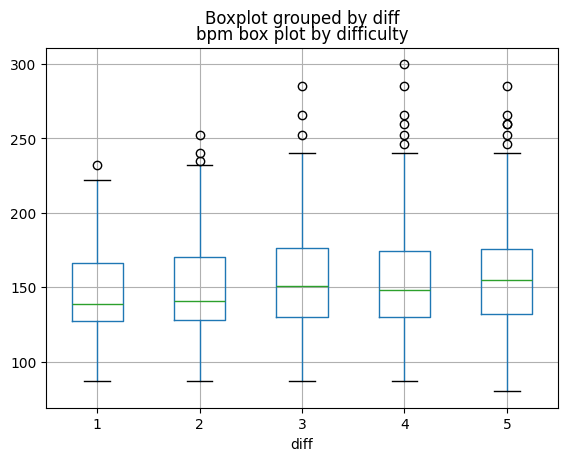

In [77]:
df_levels.boxplot(column='bpm', by='diff')
plt.title("bpm box plot by difficulty")
plt.show()

- 게임상 표기된 난이도에 따라서 평균 BPM이 증가하는 경향이 있기는 하나, BPM의 분포는 큰 차이가 없음. 이는 BPM이 맵의 난이도 보다는 맵에 삽입된 곡에 따라 결정되기 때문으로 보임
- 난이도가 높을수록 분포를 벗어난 이상치로 분류될 만큼 BPM이 높은 곡이 포진함. 하지만 역시 BPM만으로 난이도를 구분하는 것은 한계가 명확해 보임.

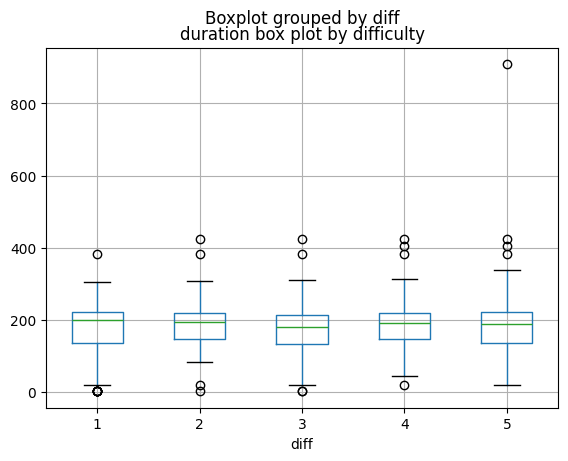

In [81]:
df_levels.boxplot(column='duration', by='diff')
plt.title("duration box plot by difficulty")
plt.show()

- 마지막 노트로 판단한 곡의 지속시간 역시, 맵이 아닌 곡에 따라 구분되기 때문에 난이도를 표현하는 지표로 사용하기 부적합.

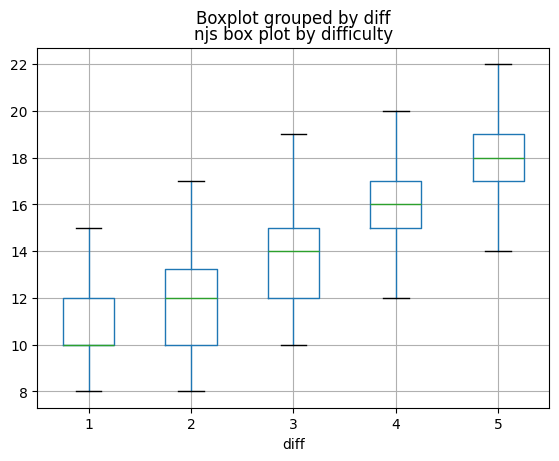

In [78]:
df_levels.boxplot(column='njs', by='diff', showfliers=False) # 이상치 제외됨.
plt.title("njs box plot by difficulty")
plt.show()

- NJS(Note Jump Speed)의 경우 난이도 상승에 따라 정비례하여 상승하는 경향을 보임.
- 따라서 레벨의 메타데이터만 볼 경우, BPM보다는 NJS가 곡의 난이도를 설명할 수 있는 좋은 지표가 될 것으로 보임.
- 문제점: 게임 내에서는 곡의 BPM만 표시해줄 뿐, NJS를 표기해주지 않음.

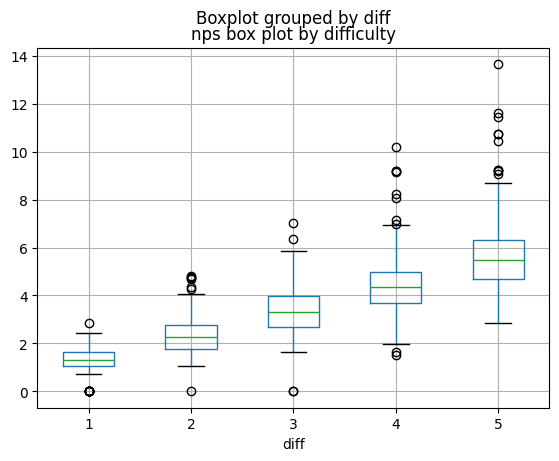

In [80]:
df_levels['note_count'] = df_levels['notes'].apply(len)
df_levels['nps'] = df_levels['note_count'] / df_levels['duration']
df_levels.boxplot(column='nps', by='diff')
plt.title("nps box plot by difficulty")
plt.show()

- NPS(Note Per Second, 초당 노트 개수)도 난이도에 따라 비례하여 상승하는 경향을 보임.
- NPS 는 게임상에서 제공되며 글자로 표기된 난이도 보다 실질적인 난이도를 판단하는데 중요하다고 생각됨.
- 다만 난이도 4와 5(Expert와 Expert+)가 겹치는 구간이 많아 이 점이 같은 NPS나 표기상 난이도에서 위화감을 느낀 원인이라고 생각됨.

In [84]:
df_test1 = pd.DataFrame(df_levels.iloc[0]['notes'])
df_test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727 entries, 0 to 726
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   b       727 non-null    float64
 1   x       727 non-null    int64  
 2   y       727 non-null    int64  
 3   t       727 non-null    int64  
 4   d       727 non-null    int64  
 5   abs     727 non-null    float64
dtypes: float64(2), int64(4)
memory usage: 34.2 KB


x   0    1    2   3
y                  
2  26   26   26  23
1  83    0    0  83
0  63  157  178  62


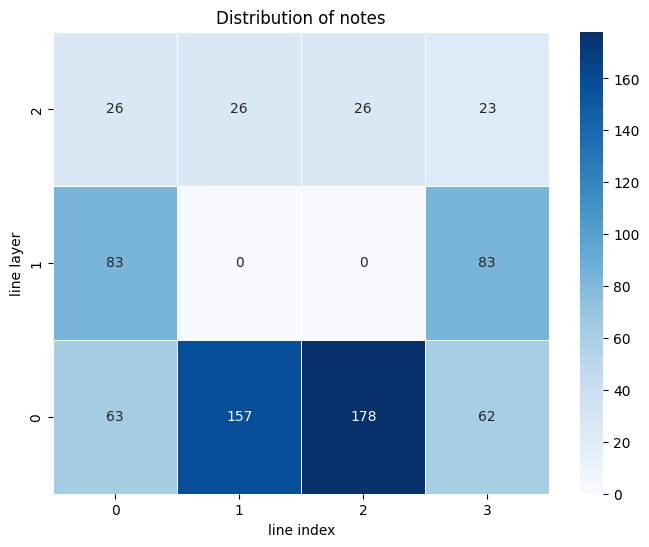

In [89]:
# !pip install seaborn
import seaborn as sns

heatmap_data = pd.crosstab(index=df_test1['y'], columns=df_test1['x'])
heatmap_data = heatmap_data.iloc[::-1]
print(heatmap_data)

plt.figure(figsize=(8,6))
sns.heatmap(
    data = heatmap_data,
    annot=True,
    fmt='d',
    cmap='Blues',
    linewidths=0.5
)

plt.title("Distribution of notes")
plt.ylabel('line layer')
plt.xlabel('line index')
plt.show()

- 첫번째 맵의 노트 분포. 주로 노트가 중앙 아랫부분에 집중된 것을 볼 수 있다.

pandas 등 라이브러리의 함수 사용법 및 문법에 대해서 구글 AI검색과 Gemini를 활용하였습니다.